# Hydrogel-Cell Interaction Test Case

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize, Bounds, brute, approx_fprime
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d
from sphere_utils import loadCoeffs, arbitrary_force, Ur_interp
from sphere_utils import usurf2umesh, dumesh_dus, usurf2vec
from sphere_utils import Tvec2Tres, usurf2dr2, calculateTfv, genSmat, genLmat, grad_usurf2dr2

## Input information

In [2]:
############################# change inputs here #################################
# Data file name
datadir = ''
smoothed = ''
dilated = ''
shapename = 'noise'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3; nu0 = 0.499;
r0 = 5;           # microns

# Arbitrary force field (opposite forces)
pF = 1            # force magnitude (Pa)
rcut_r0 = 0.3; 
rcut = rcut_r0 * r0
mag = 4; dilation = 2;
noise_level = 0.0125 # noise std (um)

# Spherical Harmonics Analysis Settings
lJmax = 20; lKmax = lJmax; lmax_plot = 60;

# initial guess settings
init_guess_type = 'ur-only' #'ur-only' or 'true'

# regularizations
# myalpha = 1     # traction magnitude
mybeta  = 0     # traction residual magnitude
mygamma = 1

# program switches
plot_figure = True
savefig = False
myord = 1; # myord: p-norm order (1-mean value)

# minimization settings
N_period = 100
maxiter_per_period = 5
CG_gtol = 1e-5
eps = 1e-5               # for jacobian

minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'disp': True, 'gtol': CG_gtol}

# dump files for minimization
savename = shapename + ('_b%.0e_g%.0e_r%.1f_n%.1e_lmax%d'%(mybeta, mygamma, rcut_r0, noise_level, lJmax))

# settings for loading \hat{U}, \hat{T} coefficients
Cmat, Dmat = loadCoeffs(mu0, nu0, lJmax, 'reg')

Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


## Define arbitrary force field

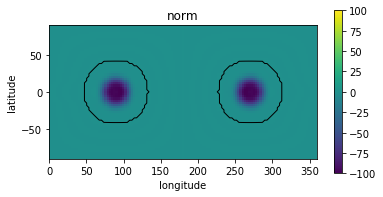

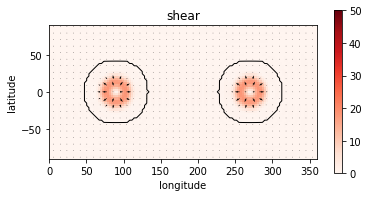

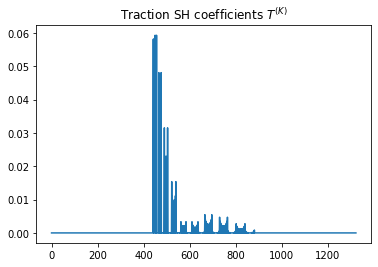

In [3]:
Tvec_true, Uvec_true, Vp, Tfv = arbitrary_force(rcut_r0, noise_level=noise_level, Cmat=Cmat, Dmat=Dmat, 
                                                plot_figure=plot_figure)

if plot_figure:
    fig, ax = plt.subplots(1, 1)
    ax.plot(np.abs(Tvec_true))
    ax.set_title('Traction SH coefficients $T^{(K)}$')
    plt.show()

In [4]:
# for rcut_r0 in [0.1, 0.3, 0.5, 0.7, 0.9]:
#     Tvec_true, Uvec_true, Vp, Tfv = arbitrary_force(rcut_r0, Cmat=Cmat, Dmat=Dmat, plot_figure=False)

#     latglq_deg, longlq_deg = pyshtools.expand.GLQGridCoord(lmax_plot)
#     theta_glq,  phi_glq = np.deg2rad(90-latglq_deg), np.deg2rad(longlq_deg)
#     dtheta = np.gradient(theta_glq)
#     dphi   = np.gradient(phi_glq)
#     PH, TH = np.meshgrid(phi_glq, theta_glq)
#     dPH, dTH = np.meshgrid(dphi, dtheta)
#     dS = dTH * np.sin(TH) * dPH
#     gridshape = (lmax_plot+1, 2*lmax_plot+1, 3)
#     Tfree_area = np.sum(Tfv.reshape(dS.shape)*dS)*r0**2
#     total_area = 4*np.pi*r0**2
#     print('rcut/r0 = %.1f, area: %.4f/%.4f = %.4f%%'%(rcut_r0, Tfree_area, total_area, Tfree_area/total_area*100))

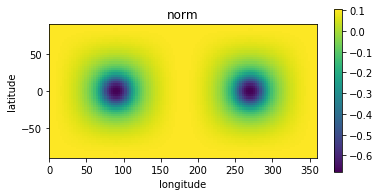

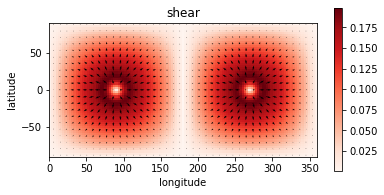

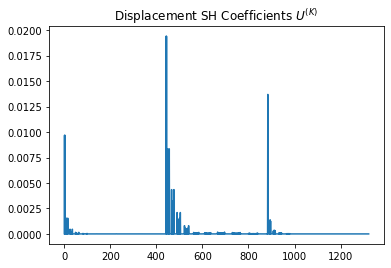

In [5]:
fig, ax = visSHVec(Uvec_true*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True,
                   config_quiver=(2, 3, 'k', 10), lonshift=180, figsize=(6,3))
fig, ax = plt.subplots()
ax.plot(np.abs(Uvec_true))
ax.set_title('Displacement SH Coefficients $U^{(K)}$')
plt.show()

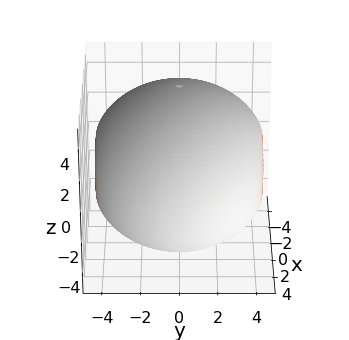

In [6]:
#%matplotlib notebook
umesh_fine_scaled = SHVec2mesh(Uvec_true, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_fine = SHVec2mesh(Tvec_true*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, r0=r0, show=False, 
                  elevation=30, azimuth=0, surface=True, figsize=(6,6))#plt.figaspect(1))
ax.set_xlabel('x', fontsize=20); ax.set_ylabel('y', fontsize=20); ax.set_zlabel('z', fontsize=20);
plt.show()

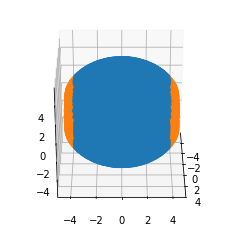

In [7]:
#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')

    Tf_id = Tfv > 0.1
    nTf_id= np.logical_not(Tf_id)
    ax.scatter3D(Vp[Tf_id, 0], Vp[Tf_id, 1], Vp[Tf_id, 2])
    ax.scatter3D(Vp[nTf_id, 0], Vp[nTf_id, 1], Vp[nTf_id, 2])

    ax.view_init(azim=0, elev=30)
    plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

Conversion between complex and real spherical harmonics, for $m>0$

$$
f_{lm} = \left[f_l^m+(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_{l-m}=i\left[f_l^m-(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_l^m = (f_{lm}-if_{l-m})/\sqrt{2}\\
f_l^{-m} = (-1)^m(f_{lm}+if_{l-m})/\sqrt{2}
$$

for $m=0$:

$$
f_{l0} = f_l^0
$$


## 1. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

## 2. Obtain the shape interpolation function

A function that returns $u_r(\theta,\varphi)$

shape fitting accuracy: 0.03540379943127405


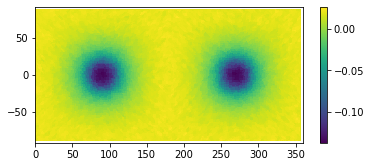

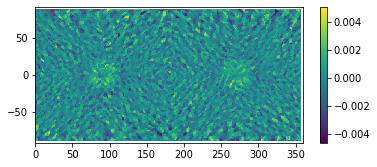

In [8]:
f_interp = Ur_interp(Vp/r0, lmax=lJmax+20, plot_figure=plot_figure)
# Define shape reference
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon0, lat0 = np.meshgrid(lonsdeg, latsdeg)
X0surf = np.stack([lat0, lon0], axis=-1)
X0 = GLQCartCoord(lJmax)

## 3. Target function including traction residual and elastic energy

We use the true solution we obtained from Section 1 `Tvec_true` for the testing. Load the initial guess as:

Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


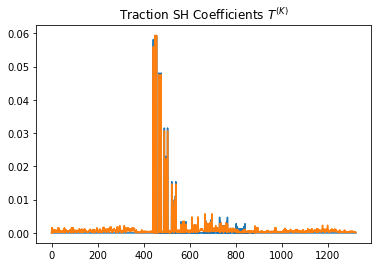

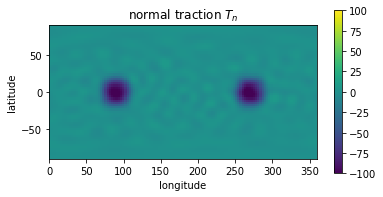

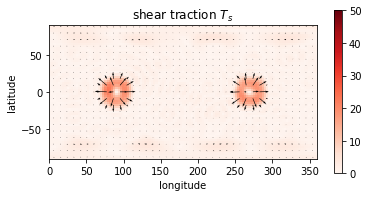

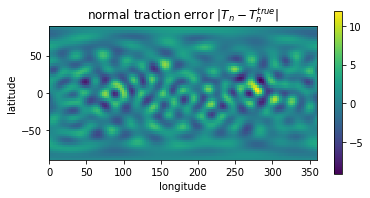

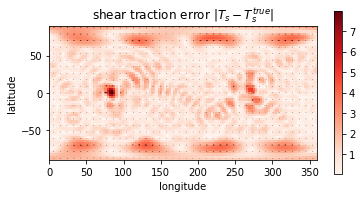

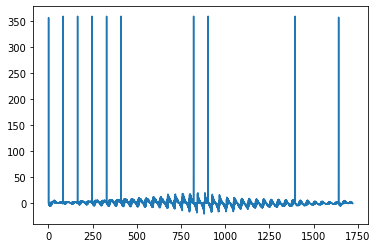

In [9]:
import glob
runspath = os.path.join('..', 'runs', 'Case06_surface_shift_gradient_penalty')
filelist = glob.glob(os.path.join(runspath, 'AK_'+savename+'_??.npz'))
nfile = len(filelist)
if nfile > 0:
    u0_surf_ref = np.load(os.path.join(runspath, 'AK_'+savename+'_%02d.npz'%(nfile-1)))['u_surf_list'][-1]
    U0vec_ref, aK_ref, T0vec_ref = usurf2vec(u0_surf_ref, f_interp=f_interp, lmax=lJmax)
    aK = np.load(os.path.join(runspath, 'AK_'+savename+'_%02d.npz'%(nfile-1)))['AK_iter']
    U0vec = Dmat.dot(aK); T0vec = Cmat.dot(aK);
    x0mesh = SHVec2mesh(U0vec, lmax=lJmax, SphCoord=False, Complex=True) + X0/r0
    r0surf, t0surf, p0surf = CartCoord_to_SphCoord(x0mesh[..., 0], x0mesh[..., 1], x0mesh[..., 2])
    lat0surf = 90 - np.rad2deg(t0surf); lon0surf = np.rad2deg(p0surf);
    u0_surf = np.stack([lat0surf, lon0surf], axis=-1) - X0surf
else: #if init_guess_type == 'true':
    print('Reconstructed solution does not exist! Visualize true solution instead')
    u0_vec = Uvec_true.copy()
    x0mesh = SHVec2mesh(u0_vec, lmax=lJmax, SphCoord=False, Complex=True) + X0/r0
    r0surf, t0surf, p0surf = CartCoord_to_SphCoord(x0mesh[..., 0], x0mesh[..., 1], x0mesh[..., 2])
    lat0surf = 90 - np.rad2deg(t0surf); lon0surf = np.rad2deg(p0surf);
    u0_surf = np.stack([lat0surf, lon0surf], axis=-1) - X0surf
    U0vec, aK, T0vec = usurf2vec(u0_surf, f_interp=f_interp, lmax=lJmax)
# elif init_guess_type == 'ur-only':
#     u0_surf = np.zeros((lJmax+1, lJmax*2+1, 2))
#     U0vec, aK, T0vec = usurf2vec(u0_surf, f_interp=f_interp, lmax=lJmax)

fig, ax = plt.subplots()
ax.plot(np.abs(Tvec_true))
#ax.plot(np.abs(T0vec_ref))
ax.plot(np.abs(T0vec))
ax.set_title('Traction SH Coefficients $T^{(K)}$')
plt.show()
figs, ax = visSHVec((T0vec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                   n_vrange=(-100, 100), s_vrange=(0, 50), show=False,
                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
ax[0].set_title('normal traction $T_n$')
ax[1].set_title('shear traction $T_s$')
plt.show()
figs, ax = visSHVec((T0vec-Tvec_true)*mu0,
                    lmax_plot=lmax_plot, SphCoord=True, Complex=True, show=False,
                   # n_vrange=(-100, 100), s_vrange=(0, 50), 
                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
ax[0].set_title('normal traction error $|T_n-T_n^{true}|$')
ax[1].set_title('shear traction error $|T_s-T_s^{true}|$')
plt.show()

fig, ax = plt.subplots()
ax.plot(u0_surf.flatten())
#ax.plot(u0_surf_ref.flatten())
plt.show()

In [10]:
# Define weights and traction free region
isTfv = calculateTfv(Uvec_true, lJmax, Vp/r0, Tfv, lat_weight=True)
print(isTfv.shape)

(21, 41)


In [11]:
T0dist = Tvec2Tres(T0vec, lJmax, isTfv=isTfv, norm_order=myord)
E0el = np.vdot(U0vec, T0vec).real*2*np.pi
print('Traction residual: %.4e Pa'%(np.sqrt(T0dist)*mu0))
print('Elastic energy: %.4e pJ'%(E0el*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(T0dist, E0el))

Traction residual: 1.6825e+00 Pa
Elastic energy: 3.9328e-04 pJ
funval: 2.8308e-04 3.1463e-02


## Coordinate transformation

The degree of freedom is defined as surface-shift $(\theta,\varphi)_i$, where $i=1\dots N, N = (l_{\max}+1)(2l_{\max}+1)$. Transformation from the surface-shift representation to displacement in Cartesian coordinates is written as:

$$
r_i = r_i(\theta_i, \varphi_i) \\
\vec{x}_i = \mathbf{Q}\cdot[r,\theta,\varphi]\\
\vec{u}_i = \vec{x}_i - \vec{X}_i
$$

We use the 3-point formulation to obtain the numerical difference:

$$
f'(x_i)\approx\frac{f(x_{i-1})+f(x_{i+1})-2f(x_{i})}{h}
$$

where $x_{i+1}-x_i=x_i-x_{i-1}=h$

### Linear transformation

The linear relation between `umesh`, `Uvec`, `Tvec`, and `Tmesh` can be written as:

$$
U_{mesh} = \sum \hat{U}_{lmk}Y_l^m\hat{\mathbf{e}}_k \\
\hat{U}_{lmk} = \mathbf{D}\cdot A_K = \mathbf{S}U_{mesh}\\
\hat{T}_{lmk} = \mathbf{C}\cdot A_K = \mathbf{C}\mathbf{D}^{-1}\mathbf{S}U_{mesh} \\
T_{mesh} = \sum \hat{T}_{lmk}Y_l^m\hat{\mathbf{e}}_k
$$

Thus it can be simplified as:

$$
T_{mesh} = \mathbf{L}U_{mesh}
$$

where $\mathbf{S}\in\mathbb{C}^{3M}\times\mathbb{C}^{3N}, \mathbf{L}\in\mathbb{R}^{3N}\times\mathbb{R}^{3N}, M=(l_{\max}+1)^2,N=(l_{\max}+1)(2l_{\max}+1)$ is the number of grid nodes on the sphere surface by GLQ meshing.

Note that $\mathbf{L}$ is positive semidefinite, which does *NOT* satisfy $L=L^T$

$\mathbf{S}$ and $\mathbf{L}$ can be obtained by operating the algorithm on each column of an *identity matrix* $I$, since they are linear operations.

## Jacobian of the target function

The target function is written as:
$$
f(\vec{u}_s)=T_{res}+\beta E_{el}=
{1\over N}\vec{T}_{mesh}^T\mathbf{P}\vec{T}_{mesh}+2\pi\beta\vec{U}^{(K)}\cdot\vec{T}^{(K)}
$$

where the surface shift $[\vec{u}_s]_i=(\theta,\varphi)_i$. Thus the Jacobian for residual traction and elastic energy can be written separately as:

$$
{\partial E_{el}\over\partial U_{mesh}}=
2\pi\left(\mathbf{S}^T\mathbf{CD^{-1}S}+\mathbf{S^TD^{-T}C}^T\mathbf{S}\right)\vec{U}_{mesh}
$$

$$
{\partial T_{res}\over\partial U_{mesh}}={2\over N}\mathbf{L}^T\mathbf{P}\mathbf{L}\vec{U}_{mesh}
$$

$$
\frac{\partial f}{\partial\vec{u}_s}=
\left[{2\over N}\mathbf{L}^T\mathbf{P}\mathbf{L}+2\pi\beta\left(\mathbf{S}^T\mathbf{CD^{-1}S}+\mathbf{S^TD^{-T}C}^T\mathbf{S}\right)\right]\vec{U}_{mesh}\frac{\partial\vec{U}_{mesh}}{\partial\vec{u}_s}
$$

where $\mathbf{P}$ is the matrix that selects the traction vector on the traction-free surface.

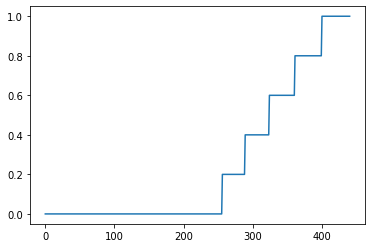

In [12]:
lmax = lJmax
ldamp_hi = lmax; ldamp_lo = lmax - 5;
lv, _ = LM_list(lmax); lv_ones = np.ones_like(lv);
lv_lim = np.minimum(np.maximum(lv, ldamp_lo), ldamp_hi)
ldamp = (np.maximum(lv_lim-ldamp_lo, 0) / (ldamp_hi - ldamp_lo))**1
Q = spm.csr_matrix(np.diag(np.tile(ldamp, 3)).astype(np.complex))
if plot_figure:
    fig, ax = plt.subplots()
    ax.plot(ldamp)
    plt.show()

In [13]:
T0dist = Tvec2Tres(T0vec, lJmax, isTfv=isTfv, norm_order=myord)
E0el = np.vdot(U0vec, T0vec).real*2*np.pi
pen0 = np.vdot(Q.dot(T0vec), Q.dot(T0vec)).real
print('Traction residual: %.4e Pa'%(np.sqrt(T0dist)*mu0))
print('Elastic energy: %.4e pJ'%(E0el*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e %.4e'%(T0dist, E0el, pen0))

Traction residual: 1.6825e+00 Pa
Elastic energy: 3.9328e-04 pJ
funval: 2.8308e-04 3.1463e-02 8.4344e-05


In [14]:
# u_surf = u0_surf.flatten().copy()

Usurfvec, aK, Tsurfvec = U0vec, aK, T0vec # usurf2vec(u_surf, f_interp, lJmax, X0surf=X0surf, X0=X0, Cmat=Cmat, Dmat=Dmat)
Tsurfdist = Tvec2Tres(Tsurfvec, lJmax, isTfv=isTfv, norm_order=myord)
Esurfel = np.vdot(Usurfvec, Tsurfvec).real*2*np.pi
print('Traction residual: %.4e Pa'%(np.sqrt(Tsurfdist)*mu0))
print('Elastic energy: %.4e pJ'%(Esurfel*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(Tsurfdist, Esurfel))

Traction residual: 1.6825e+00 Pa
Elastic energy: 3.9328e-04 pJ
funval: 2.8308e-04 3.1463e-02


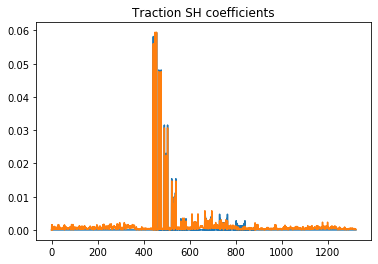

Text(0.5, 1.0, 'Shear traction error $|T_s - T_s^{true}|$')

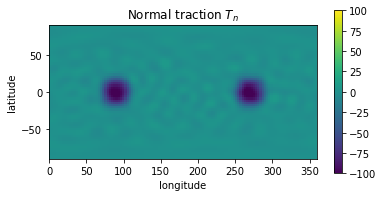

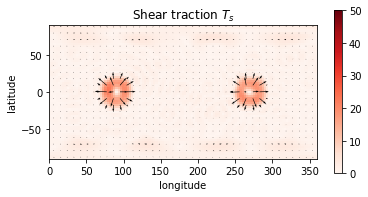

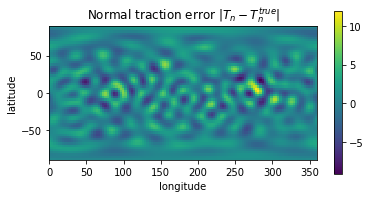

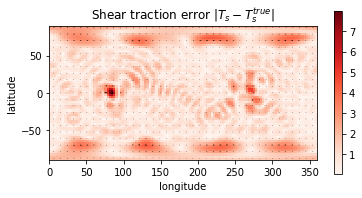

In [15]:
fig, ax = plt.subplots()
ax.plot(np.abs(Tvec_true), label='True solution')
ax.plot(np.abs(Tsurfvec),  label='Reconstructed')
ax.set_title('Traction SH coefficients')
plt.show()

fig, ax = visSHVec((Tsurfvec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                   n_vrange=(-100, 100), s_vrange=(0, 50), show=False,
                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
ax[0].set_title('Normal traction $T_n$')
ax[1].set_title('Shear traction $T_s$')
fig, ax = visSHVec((Tsurfvec-Tvec_true)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                   #n_vrange=(-100, 100), s_vrange=(0, 50), 
                   show=False,
                   config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))
ax[0].set_title('Normal traction error $|T_n - T_n^{true}|$')
ax[1].set_title('Shear traction error $|T_s - T_s^{true}|$')

Visualize the shape in 3D...


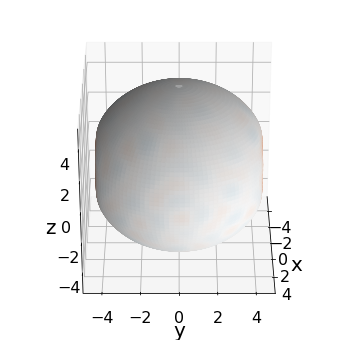

In [16]:
%matplotlib inline
#umesh1 = SHVec2mesh(U0vec, lmax=lJmax, SphCoord=False, Complex=True)
#tmesh1 = SHVec2mesh(T0vec*mu0, lmax=lJmax, SphCoord=False, Complex=True)
umesh_fine_scaled = SHVec2mesh(Usurfvec, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_fine = SHVec2mesh(Tsurfvec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_sph_fine = SHVec2mesh(Tsurfvec*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)
print('Visualize the shape in 3D...')
fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, 
                  r0=r0, show=False, vmin=-100, vmax=100,
                  elevation=30, azimuth=0, 
                  surface=True, figsize=(6,6))#(8,6))

# reference data
nTfv = np.logical_not(Tfv)
#ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
#ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
#ax.set_title('Front view')
ax.set_xlabel('x', fontsize=20); ax.set_ylabel('y', fontsize=20); ax.set_zlabel('z', fontsize=20);
if savefig:
    plt.tight_layout(); plt.savefig(savename+'_front.png', transparent=True)
plt.show()

In [17]:
Vlat, Vlon = pyshtools.expand.GLQGridCoord(lmax_plot)
xmesh = (GLQCartCoord(lmax_plot) + umesh_fine_scaled) * r0
umesh_true_scaled = SHVec2mesh(Uvec_true, lmax=lmax_plot, SphCoord=False, Complex=True)
umesh_sph_true = SHVec2mesh(Uvec_true, lmax=lmax_plot, SphCoord=True, Complex=True)
xmesh_true = (GLQCartCoord(lmax_plot) + umesh_true_scaled) * r0
tmesh_true = SHVec2mesh(Tvec_true*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_sph_true = SHVec2mesh(Tvec_true*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)
savemat(savename+'.mat', {'lat':Vlat, 'lon':Vlon, 'r0':r0, 'mu0':mu0, 
                          'xmesh': xmesh, 'tmesh_Cart': tmesh_fine, 'tmesh_Sph': tmesh_sph_fine,
                          'xmesh_true': xmesh_true, 'tmesh_true_Cart': tmesh_true, 'tmesh_true_Sph': tmesh_sph_true})